In [1]:
from pycaret.regression import *
import pandas as pd
import numpy as np 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
from scipy import stats 

import missingno as msno 
plt.style.use('seaborn') 
import warnings 
warnings.filterwarnings("ignore") 
mpl.rcParams['axes.unicode_minus'] = False 
%matplotlib inline
from scipy.stats import norm
#Import & Data check
#기본적인 모듈 import

In [2]:
df_train=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')
submission=pd.read_csv('submission.csv')
data=df_train
print(df_train.shape, df_test.shape, submission.shape)

(1459, 11) (715, 10) (715, 2)


In [3]:
reg = setup(df_train, target='count', train_size=0.8)

,Description,Value
0,session_id,7729
1,Target,count
2,Original Data,"(1459, 11)"
3,Missing Values,True
4,Numeric Features,9
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1167, 12)"


In [4]:
best_model = compare_models(sort = 'RMSE')
# 모델 비교의 경우 기본적으로 k-fold cv로 값을 비교하게 된다.(k=10)
# 본 과업에서의 평가지표는 'RMSE'이기 때문에 해당 지표를 기준으로 내림차순을 설정해 비교했다.

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,24.4238,1299.4977,35.9144,0.8038,0.4991,0.7457,0.0870
lightgbm,Light Gradient Boosting Machine,25.9370,1431.2264,37.7126,0.7831,0.5581,0.7850,0.0140
rf,Random Forest Regressor,26.2060,1481.3291,38.3720,0.7773,0.5214,0.8530,0.1200
gbr,Gradient Boosting Regressor,26.7519,1529.3228,38.9836,0.7688,0.5430,0.8675,0.0290
ridge,Ridge Regression,39.8046,2837.2720,53.1070,0.5767,0.8041,1.2868,0.0040
lr,Linear Regression,39.8004,2839.1724,53.1196,0.5766,0.8031,1.2948,0.2210
lar,Least Angle Regression,39.8004,2839.1730,53.1196,0.5766,0.8031,1.2948,0.0050
br,Bayesian Ridge,39.7648,2852.6664,53.2436,0.5742,0.8111,1.3573,0.0040
lasso,Lasso Regression,39.8173,2868.9420,53.3877,0.5717,0.8012,1.3988,0.1770
dt,Decision Tree Regressor,35.5642,2922.0874,53.6682,0.5599,0.6805,1.1042,0.0050


In [5]:
# 모델 생성(create)
# 위 모델 비교결과를 기준으로 상위 3개의 모델만 생성해 활용을 해본다. 이미 성능 평가 비교를 했기 때문에 cv=False

et = create_model('et', cross_validation=False)
lightgbm = create_model('lightgbm', cross_validation=False)
rf = create_model('rf', cross_validation=False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,27.5337,1564.9019,39.5588,0.7728,0.459,0.5464


In [6]:
# 하이퍼파라미터 튜닝
# 모델 하이퍼파라미터 튜닝(Tune)

tuned_et = tune_model(et, optimize='RMSE', n_iter=10)
tuned_lightgbm = tune_model(lightgbm, optimize='RMSE', n_iter=10)
tuned_rf = tune_model(rf, optimize='RMSE', n_iter=10)

'''
모델 튜닝에는 기본적으로 K-Fold CV를 바탕으로 진행되며 최적화는 과업에 맞게 'RMSE"를 선택해 진행했다.
튜닝 방법은 일반적으로 Random Grid를 iter(default=10)만큰 최적화 시킨다.
해당 방법 외 custom grid 파라미터를 추가하여 튜닝을 진행할 수 있다.
'''

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,30.2689,2051.6516,45.2952,0.7103,0.5704,0.7550
1,30.7744,1860.8093,43.1371,0.7339,0.6275,1.2287
2,26.5083,1484.2506,38.5260,0.7877,0.3838,0.3550
3,27.0821,1637.6331,40.4677,0.7290,0.5211,0.7002
4,26.7877,1669.4426,40.8588,0.8044,0.4512,0.4743
5,22.6228,1221.9084,34.9558,0.7743,0.3944,0.3706
6,28.6681,1684.9192,41.0478,0.7646,0.5656,0.8693
7,26.9440,1673.3555,40.9067,0.7723,0.6810,1.5644
8,24.6241,1463.5642,38.2566,0.7260,0.7022,2.1100


'\n모델 튜닝에는 기본적으로 K-Fold CV를 바탕으로 진행되며 최적화는 과업에 맞게 \'RMSE"를 선택해 진행했다.\n튜닝 방법은 일반적으로 Random Grid를 iter(default=10)만큰 최적화 시킨다.\n해당 방법 외 custom grid 파라미터를 추가하여 튜닝을 진행할 수 있다.\n'

In [7]:
# 블렌딩
# 모델 블렌딩(Blend)

blender_specific = blend_models(estimator_list = [tuned_et,tuned_lightgbm,tuned_rf])

'''
튜닝이 끝난 모델 3개를 앙상블(여러개의 결정 트리를 결합하여 하나의 결정 트리보다 더 좋은 성능을 내는 머신러닝 기법 - 여러개의 모델을 조화롭게 학습시켜 그 모델들의 예측결과들을 이용한다.) 하는 작업이다.
기본적으로 전체 데이터셋을 사용하며 10-fold, RMSE로 최적화를 시켰다.
오히려 일반 단일 모델에 비해 성능이 낮게 나왔다.
아마 튜닝 하는 과정에서 랜덤 서치다보니 성능이 매우 낮게 튜닝된듯 보인다.
하지만 앙상블 작업을 진행했기 때문에 단일 모델에 비해 일반화 성능은 아마 더 좋을것이다.
'''

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,28.5679,1801.6207,42.4455,0.7456,0.5506,0.7234
1,29.0440,1550.2917,39.3737,0.7783,0.6115,1.0758
2,24.4554,1274.0343,35.6936,0.8178,0.3830,0.3476
3,25.4207,1430.9687,37.8281,0.7632,0.4838,0.6149
4,25.6969,1546.7630,39.3289,0.8188,0.4291,0.4308
5,21.8623,1068.5387,32.6885,0.8026,0.4064,0.4048
6,26.1277,1412.2863,37.5804,0.8027,0.5455,0.8103
7,25.9877,1496.9479,38.6904,0.7963,0.6710,1.5363
8,23.9745,1363.0769,36.9199,0.7448,0.6971,2.1960


'\n튜닝이 끝난 모델 3개를 앙상블(여러개의 결정 트리를 결합하여 하나의 결정 트리보다 더 좋은 성능을 내는 머신러닝 기법 - 여러개의 모델을 조화롭게 학습시켜 그 모델들의 예측결과들을 이용한다.) 하는 작업이다.\n기본적으로 전체 데이터셋을 사용하며 10-fold, RMSE로 최적화를 시켰다.\n오히려 일반 단일 모델에 비해 성능이 낮게 나왔다.\n아마 튜닝 하는 과정에서 랜덤 서치다보니 성능이 매우 낮게 튜닝된듯 보인다.\n하지만 앙상블 작업을 진행했기 때문에 단일 모델에 비해 일반화 성능은 아마 더 좋을것이다.\n'

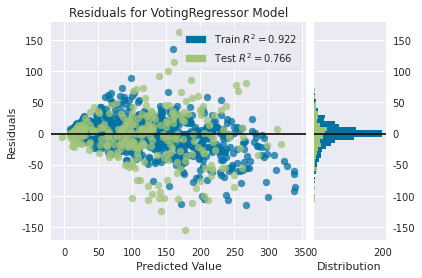

'\ntrain/test 유사분포\ntest set에 비해 train set 설명력이 매우 높은 것으로 보아 과적합을 의심해볼 수 있다.\ntrain/test 모두 아웃라이어 제거가 필요해보인다.\n'

In [8]:
# 시각화
# 모델 시각화(plot)

plot_model(blender_specific)

'''
train/test 유사분포
test set에 비해 train set 설명력이 매우 높은 것으로 보아 과적합을 의심해볼 수 있다.
train/test 모두 아웃라이어 제거가 필요해보인다.
'''

In [9]:
# 학습 및 예측
# 마지막 학습 및 예측(Finalize, Predict)

# 마지막 학습(Finalize)
final_model = finalize_model(blender_specific)

# 예측(Predict)
prediction = predict_model(final_model, data=df_test)

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 

In [10]:
print(prediction['Label'])

0       89.358604
1      213.251807
2       68.769458
3       38.129963
4       70.387942
          ...    
710     62.353749
711     63.734249
712    114.202555
713    165.449944
714    153.624366
Name: Label, Length: 715, dtype: float64


In [11]:
submission['count'] = prediction['Label']
print(submission[:10])
submission.to_csv('automl_ddareungi2.csv')

   id       count
0   0   89.358604
1   1  213.251807
2   2   68.769458
3   4   38.129963
4   5   70.387942
5  10  134.560972
6  11  187.272074
7  12  269.296546
8  15   31.701487
9  17   98.876261
